The below code implements the textbook definition of the Intrinsic Time-Scale Decomposition algorithm, by Frei and Osorio(2006). Note that the algorithm is patented at the present time(2022) with expiration in two years. The usage of this algorithm for research purposes in certain countries may be restricted.
https://www.oecd.org/science/inno/36311146.pdf 

China, Iceland, Japan, Korea, Mexico, Norway and Turkey, Austria, Belgium, the Czech Republic,
Denmark, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Luxembourg, the Netherlands,
Poland, Portugal, Slovakia, Spain, Sweden and the United Kingdom all have research exeptions or legal constraints to the rights of patent owners that provide for the use in research(but not commercially) of patented code.

However, in the United States ,‘formal research enjoys no absolute protection from infringement liability regardless of the institutional venue, the purpose of the inquiry, the origin of the patented inventions, or the use that is made of them'.As a result, your usage of this algorithm carries with it strict liability concerns and your incorporation of it into your work must be limited to research publications of a strictly academic nature- that is to say, you may make publications relating to this algorithm, but you may not for any purpose make software based upon it or incorporate it into other packages until the license has expired. For those interested in obtaining a license, I suggest contacting flint hills scientific by mail at 5040 Bob Billings Pkwy, Ste A, Lawrence, KS 66049-3843

In [1]:
#!/usr/bin/python
# coding: UTF-8
#
# Author:  Chronum94, Falsywichnet, template and some code shamelessly copied from Dawid Laszuk

#!/usr/bin/python
# coding: UTF-8
#
# Author:  Chronum94, Falsywichnet, template shamelessly copied from Dawid Laszuk
# Contact:  https://github.com/falsywinchnet/PyITD/issues
#
# Feel free to contact for any information.

from typing import Optional, Tuple

import numba
import numpy

FindExtremaOutput = Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]

@numba.njit(numba.boolean[:](numba.int64[:],numba.int64[:]),parallel=True)
def isin(a, b):
        out=numpy.empty(a.shape[0], dtype=numba.boolean)
        b = set(b)
        for i in numba.prange(a.shape[0]):
            if a[i] in b:
                out[i]=True
            else:
                out[i]=False
        return out
@numba.njit(numba.int64[:](numba.float64[:]))
def detect_peaks(x: list[float]):
    """Detect peaks in data based on their amplitude and other features.
    warning: this code is an optimized copy of the "Marcos Duarte, https://github.com/demotu/BMC"
    matlab compliant detect peaks function intended for use with data sets that only want
    rising edge and is optimized for numba. experiment with it at your own peril.
    """
    # find indexes of all peaks
    x = numpy.asarray(x)
    if len(x) < 3:
        return numpy.empty(1, numpy.int64)
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = numpy.where(numpy.isnan(x))[0]
    indl = numpy.asarray(indnan)

    if indl.size!= 0:
        x[indnan] = numpy.inf
        dx[numpy.where(numpy.isnan(dx))[0]] = numpy.inf

    vil = numpy.zeros(dx.size + 1)
    vil[:-1] = dx[:]# hacky solution because numba does not like hstack tuple arrays
    #numpy.asarray((dx[:], [0.]))# hacky solution because numba does not like hstack
    vix = numpy.zeros(dx.size + 1)
    vix[1:] = dx[:]

    ind = numpy.unique(numpy.where((vil > 0) & (vix <= 0))[0])

            
       
    # handle NaN's
    # NaN's and values close to NaN's cannot be peaks
    if ind.size and indl.size:
        outliers = numpy.unique(numpy.concatenate((indnan, indnan - 1, indnan + 1)))
        booloutliers = isin(ind, outliers)
        booloutliers = numpy.invert(booloutliers)
        ind = ind[booloutliers]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
        
    #eliminate redundant values
    return numpy.unique(ind)

#TODO: implement end knots optional
@numba.jit(numba.types.Tuple((numba.float64[:],numba.float64[:]))(numba.float64[:]))
def itd_baseline_extract(data: list[numpy.float64])-> Tuple[numpy.ndarray, numpy.ndarray]:

        x = numpy.asarray(data,dtype=numpy.float64)
        rotation = numpy.zeros_like(x)

        alpha=0.5
        # signal.find_peaks_cwt(x, 1)
        idx_max =numpy.asarray(detect_peaks(x))
        idx_min= numpy.asarray(detect_peaks(-x))
        val_max = x[idx_max] #get peaks based on indexes
        val_min = x[idx_min]
        val_min= -val_min
    
        num_extrema = len(val_max) + len(val_min)

        extremabuffersize = num_extrema + 2
        extrema_indices = numpy.zeros(extremabuffersize, dtype=numpy.int64)
        extrema_indices[1:-1] = numpy.sort(numpy.unique(numpy.hstack((idx_max,idx_min)))) 
        extrema_indices[-1] = len(x) - 1
    
        baseline_knots = numpy.zeros(len(extrema_indices))
        baseline_knots[0] = numpy.mean(x[:2])
        baseline_knots[-1] = numpy.mean(x[-2:])
        #also reflections possible, but should be treated with caution

        #j = extrema_indices, k = k, baseline_knots = B, x =  τ
        for k in range(1, len(extrema_indices) - 1):
            baseline_knots[k] = alpha * (x[extrema_indices[k - 1]] + \
            (extrema_indices[k] - extrema_indices[k - 1]) / (extrema_indices[k + 1] - extrema_indices[k - 1]) * \
            (x[extrema_indices[k + 1]] - x[extrema_indices[k - 1]])) + \
                           alpha * x[extrema_indices[k]]
    
        baseline_new = numpy.zeros_like(x)

        for k in range(0, len(extrema_indices) - 1):
            baseline_new[extrema_indices[k]:extrema_indices[k + 1]] = baseline_knots[k]  + \
            (baseline_knots[k + 1] - baseline_knots[k]) / (x[extrema_indices[k + 1]] - x[extrema_indices[k]]) * \
            (x[extrema_indices[k]:extrema_indices[k + 1]] - x[extrema_indices[k]])
    
        rotation[:] = numpy.subtract(x, baseline_new)

        return rotation[:] , baseline_new[:]
    
class ITD:
    """
    .. _ITD:
    **Intrinsic Time-Scale Decomposition**
    Method of decomposing signal into Intrinsic Baselines (IB)
    based on algorithm presented in Frei et al. [Frei2007]_.
    Algorithm was validated with Restrepo et al. [Restrepo2014]_ simplified algorithm representation.
    Threshold which control the goodness of the decomposition:
        * `end_knots` --- set the end knots. defaults to mean

    References
    ----------
    .. [Frei2007] Frei, Mark G.; Osorio, Ivan (2007). "Intrinsic time-scale decomposition: 
    time–frequency–energy analysis and real-time filtering of non-stationary signals". 
    Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 
    463(2078), 321–342. doi:10.1098/rspa.2006.1761 

    .. [Restrepo2014] Restrepo, Juan M; Venkataramani, Shankar; Comeau, Darin; Flaschka, Hermann (2014). 
    Defining a trend for time series using the intrinsic time-scale decomposition. 
    New Journal of Physics, 16(8), 085004–. doi:10.1088/1367-2630/16/8/085004 
    
    Examples
    --------
    >>> import numpy
    >>> T = numpy.linspace(0, 1, 100)
    >>> S = numpy.sin(2*2*numpy.pi*T)
    >>> itd = ITD(extrema_detection='parabol')
    >>> IB = itd.itd(S)
    >>> IB.shape
    (6, 100)
    """

    #logger = logging.getLogger(__name__)

    def __init__(self, extrema_detection: str = "matlab"):
        """Initiate *ITD* instance.
        Parameters
        ----------
        FIXE : int (default: 0)
        FIXE_H : int (default: 0)
        MAX_ITERATION : int (default 11)
            Maximum number of baselines to decompose
        extrema_detection : str (default 'matlab')
            Method used to finding extrema.
            The matlab method is modified to identify extrema with only one side(plateau) 
            and shift them to the right, per the ITD research paper. Simple and parabola copied from PyEMD
        DTYPE : numpy.dtype (default numpy.float64)
            Data type used.
        Examples
        --------
        >>> itd = ITD(extrema_detection=parabol)
        """
        self.extrema_detection = extrema_detection
        # Declare constants
        assert self.extrema_detection in (
            "simple",
            "parabol",
            "matlab",
        ), "Only 'simple', 'matlab', and 'parabol' values supported"

        self.DTYPE = numpy.float64

        # Instance global declaration
        self.rotations = None  # Optional[numpy.ndarray]
        self.baselines = None  # Optional[numpy.ndarray]

    def __call__(self, S: numpy.ndarray, max_iterations: int = 12) -> numpy.ndarray:
        return self.itd(S, max_iterations=max_iterations)
    
    @staticmethod
    def _not_duplicate(S: numpy.ndarray) -> numpy.ndarray:
        """
        Returns indices for not repeating values, where there is no extremum.
        Example
        -------
        >>> S = [0, 1, 1, 1, 2, 3]
        >>> idx = self._not_duplicate(S)
        [0, 1, 3, 4, 5]
        """
        dup = numpy.r_[S[1:-1] == S[0:-2]] & numpy.r_[S[1:-1] == S[2:]]
        not_dup_idx = numpy.arange(1, len(S) - 1)[~dup]

        idx = numpy.empty(len(not_dup_idx) + 2, dtype=numpy.int64)
        idx[0] = 0
        idx[-1] = len(S) - 1
        idx[1:-1] = not_dup_idx

        return idx
        
    @staticmethod
    def _common_dtype(x: numpy.ndarray, y: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray]:
        """Casts inputs (x, y) into a common numpy DTYPE."""
        dtype = numpy.find_common_type([x.dtype, y.dtype], [])
        if x.dtype != dtype:
            x = x.astype(dtype)
        if y.dtype != dtype:
            y = y.astype(dtype)
        return x, y
         
    def _prepare_points_simple(
        self,
        T: numpy.ndarray,
        S: numpy.ndarray,
        max_pos: numpy.ndarray,
        max_val: Optional[numpy.ndarray],
        min_pos: numpy.ndarray,
        min_val: Optional[numpy.ndarray],
    ) -> Tuple[numpy.ndarray, numpy.ndarray]:
        """
        Performs mirroring on signal which extrema can be indexed on
        the position array.
        See :meth:`EMD.prepare_points`.
        """

        # Find indexes of pass
        ind_min = min_pos.astype(int)
        ind_max = max_pos.astype(int)

        # Local variables
        nbsym = self.nbsym
        end_min, end_max = len(min_pos), len(max_pos)

        ####################################
        # Left bound - mirror nbsym points to the left
        if ind_max[0] < ind_min[0]:
            if S[0] > S[ind_min[0]]:
                lmax = ind_max[1 : min(end_max, nbsym + 1)][::-1]
                lmin = ind_min[0 : min(end_min, nbsym + 0)][::-1]
                lsym = ind_max[0]
            else:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
                lmin = numpy.append(ind_min[0 : min(end_min, nbsym - 1)][::-1], 0)
                lsym = 0
        else:
            if S[0] < S[ind_max[0]]:
                lmax = ind_max[0 : min(end_max, nbsym + 0)][::-1]
                lmin = ind_min[1 : min(end_min, nbsym + 1)][::-1]
                lsym = ind_min[0]
            else:
                lmax = numpy.append(ind_max[0 : min(end_max, nbsym - 1)][::-1], 0)
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]
                lsym = 0

        ####################################
        # Right bound - mirror nbsym points to the right
        if ind_max[-1] < ind_min[-1]:
            if S[-1] < S[ind_max[-1]]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = ind_min[max(end_min - nbsym - 1, 0) : -1][::-1]
                rsym = ind_min[-1]
            else:
                rmax = numpy.append(ind_max[max(end_max - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = len(S) - 1
        else:
            if S[-1] > S[ind_min[-1]]:
                rmax = ind_max[max(end_max - nbsym - 1, 0) : -1][::-1]
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]
                rsym = ind_max[-1]
            else:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
                rmin = numpy.append(ind_min[max(end_min - nbsym + 1, 0) :], len(S) - 1)[::-1]
                rsym = len(S) - 1

        # In case any array missing
        if not lmin.size:
            lmin = ind_min
        if not rmin.size:
            rmin = ind_min
        if not lmax.size:
            lmax = ind_max
        if not rmax.size:
            rmax = ind_max

        # Mirror points
        tlmin = 2 * T[lsym] - T[lmin]
        tlmax = 2 * T[lsym] - T[lmax]
        trmin = 2 * T[rsym] - T[rmin]
        trmax = 2 * T[rsym] - T[rmax]

        # If mirrored points are not outside passed time range.
        if tlmin[0] > T[0] or tlmax[0] > T[0]:
            if lsym == ind_max[0]:
                lmax = ind_max[0 : min(end_max, nbsym)][::-1]
            else:
                lmin = ind_min[0 : min(end_min, nbsym)][::-1]

            if lsym == 0:
                raise Exception("Left edge BUG")

            lsym = 0
            tlmin = 2 * T[lsym] - T[lmin]
            tlmax = 2 * T[lsym] - T[lmax]

        if trmin[-1] < T[-1] or trmax[-1] < T[-1]:
            if rsym == ind_max[-1]:
                rmax = ind_max[max(end_max - nbsym, 0) :][::-1]
            else:
                rmin = ind_min[max(end_min - nbsym, 0) :][::-1]

            if rsym == len(S) - 1:
                raise Exception("Right edge BUG")

            rsym = len(S) - 1
            trmin = 2 * T[rsym] - T[rmin]
            trmax = 2 * T[rsym] - T[rmax]

        zlmax = S[lmax]
        zlmin = S[lmin]
        zrmax = S[rmax]
        zrmin = S[rmin]

        tmin = numpy.append(tlmin, numpy.append(T[ind_min], trmin))
        tmax = numpy.append(tlmax, numpy.append(T[ind_max], trmax))
        zmin = numpy.append(zlmin, numpy.append(S[ind_min], zrmin))
        zmax = numpy.append(zlmax, numpy.append(S[ind_max], zrmax))

        max_extrema = numpy.array([tmax, zmax])
        min_extrema = numpy.array([tmin, zmin])

        # Make double sure, that each extremum is significant
        max_dup_idx = numpy.where(max_extrema[0, 1:] == max_extrema[0, :-1])
        max_extrema = numpy.delete(max_extrema, max_dup_idx, axis=1)
        min_dup_idx = numpy.where(min_extrema[0, 1:] == min_extrema[0, :-1])
        min_extrema = numpy.delete(min_extrema, min_dup_idx, axis=1)

        return max_extrema, min_extrema    

    def itd(self, data: numpy.ndarray, max_iteration: int = 11) -> numpy.ndarray:
        """
        Performs Intrisic Time-Scale Decomposition on signal S.
        The decomposition is limited to *max_iteration* baselines.
        Returns proper rotations in numpy array format, along with the final residual trend.
        Parameters
        ----------
        data : numpy array,
            Input signal.
        max_imf : int, (default: 11)
            IPR number to which decomposition should be performed.
        Returns
        -------
        IPR : numpy array
            Set of rotations produced from input signal.
        """
        # Make sure same types are dealt
        self.DTYPE = data.dtype
        N = len(data)

        residue = data.astype(self.DTYPE)
        imf = numpy.zeros(len(data), dtype=self.DTYPE)
        imf_old = numpy.nan

        # Create arrays
        imfNo = 22
        IPR = numpy.empty((imfNo, N))  # Numpy container for IMF
        finished = False

        
        rotations = numpy.zeros((22,len(data)),dtype=numpy.float64)
        baselines = numpy.zeros((22,len(data)),dtype=numpy.float64)
        rotation_ = numpy.zeros((len(data)),dtype=numpy.float64)
        baseline_ = numpy.zeros((len(data)),dtype=numpy.float64)
        r = numpy.zeros((len(data)),dtype=numpy.float64)
        rotation_[:], baseline_[:] = itd_baseline_extract(numpy.transpose(numpy.asarray(data,dtype=numpy.float64))) 
        counter = 0
        while not finished:         

            idx_max =numpy.asarray(detect_peaks(baseline_))
            idx_min= numpy.asarray(detect_peaks(-baseline_))
            num_extrema = len(idx_min) + len(idx_max)
            if num_extrema < 2:
                #is the new baseline decomposable?
                print("No more decompositions possible")
                #implied: last decomposition was invalid!
                #not always the case, but efforts to decompose the trend which are meaningful
                #require a little adjustment to get the baseline monotonic trend to show properly.
                r[:] = baselines[counter-1,:]
                rotations[counter,:] = r[:]
                counter = counter + 1      
                self.rotations = rotations[0:counter,:]
                self.baselines = baselines[0:counter-1,:]
                #self.logger.debug("Baseline -- %s", counter)
                return self.rotations

            elif counter > max_iteration:
                print("Out of time!")
                r[:] = numpy.add(rotation_[:],baseline_[:])
                rotations[counter,:] = r[:]
                counter = counter + 1   #why is this necessary? 
                self.rotations = rotations[0:counter,:]
                self.baselines = baselines[0:counter,:]
                #self.logger.debug("Baseline -- %s", counter)
                return self.rotations

            else: #results are sane, so perform an extraction.
                rotations[counter,:] = rotation_[:]
                baselines[counter,:] =  baseline_[:]
                rotation_[:],  baseline_[:] = itd_baseline_extract(baseline_[:])
                counter = counter + 1   
            #self.logger.debug("Baseline -- %s", counter)


    def get_baselines(self) -> numpy.ndarray:
        """
        Provides access to separated baselines from recently analysed signal.
        Returns
        -------
        baselines : numpy.ndarray
            Obtained baselines

        """
        if self.baselines is None:
            raise ValueError("No baselines found. Please, run ITD method or its variant first.")
        return self.baselines

    def get_rotations(self) -> numpy.ndarray:
        """
        Provides access to separated rotations and residue from recently analysed signal.
        Note that this may differ from the `get_rotations_and_residual` as the baseline isn't
        necessarily the residue. Residue is a final summation when rotation is no longer possible,
        wheras baselines are all remainder Bj1 = Bj - R, all rotation output must sum to 0.
        Returns
        -------
        iprs : numpy.ndarray
            Obtained IPRs
        B : numpy.ndarray
            The baselines.
        """
        if self.rotations is None:
            raise ValueError("No IPR found. Please, run ITD method or its variant first.")
        else:
            return self.rotations


###################################################

/tmp/ipykernel_20839/3599281445.py:78: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(numba.types.Tuple((numba.float64[:],numba.float64[:]))(numba.float64[:]))


In [55]:
from nemo.make_df import make_df

data = make_df('nemo/2023-2023/Measured_data/24_02-02_03')

dates = data['date']
values = data['value'].values

Out of time!
difference between input and ITD output after re-combining all values:  1.1358969320696133e-14


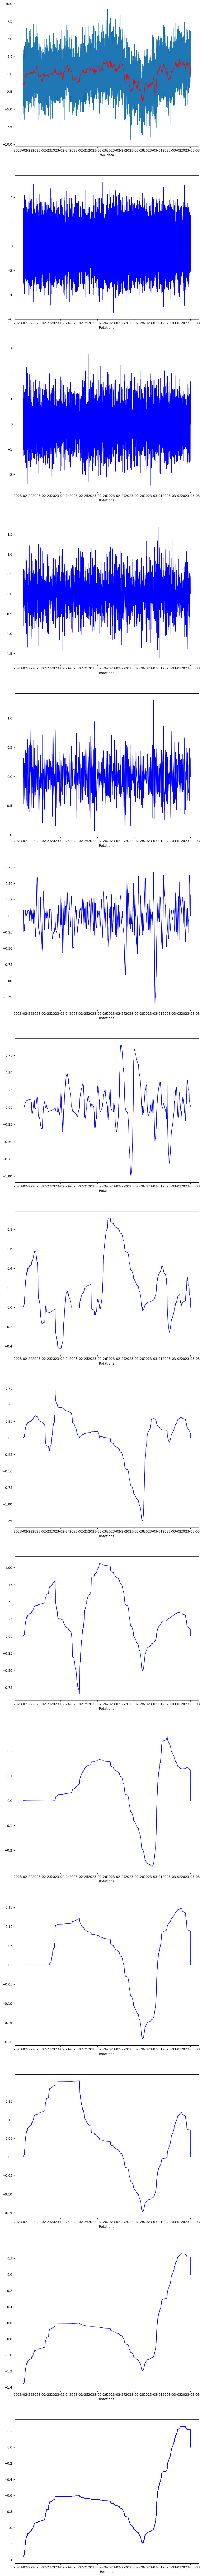

In [67]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import numpy
import math
itd = ITD()


def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)


samples = numpy.asarray(values) 
rotations = itd.itd(samples)
baselines = itd.get_baselines()
rows, columns = baselines.shape
diff = abs(numpy.sum(samples) -  (shewchuk_sum(rotations)))
print("difference between input and ITD output after re-combining all values: ", diff)
fig, (ax) = plt.subplots(rows+2,figsize=(10,(rows * 10) + 10))

ax[0].set_xlabel('raw data')
ax[0].plot(dates, samples)
ax[0].plot(dates, baselines[3,:], 'r') #Значением baselines[n,:] можно поиграться
for i in range(rows):
    ax[i+1].set_xlabel('Rotations')
    ax[i+1].plot(dates, rotations[i,:],'b')                             
    ax[-1].set_xlabel('Residual')
    ax[-1].plot(dates, rotations[-1,:],'b')                                

Notes and exerpt quotations from articles around the web:


empirical wavelet transform (EWT) [16] combines aspects of EMD with the wavelet transform. The
main idea behind EWT is to partition the Fourier domain and build empirical wavelet filters from
the segmented spectrum. This is done by identifying local maxima of the amplitude in the Fourier
domain and partitioning the regions to separate the maxima [26]. The EWT was extended to two
dimensions for applications in imaging and can be related to other wavelet-like transforms [17].
https://arxiv.org/pdf/2204.06108.pdf notes from this article


The interesting fact about this algorithm(EMD) is that it is highly
adaptable and is able to extract the non-stationary part of the
original function. However, its main problem is that it is based
on an ad-hoc process which is mathematically difficult to model.
Consequently it is difficult to really understand what the EMD
provides. For example, some problems appear when some noise
is present in the signal. To deal with this problem, an Ensemble
EMD (EEMD) was proposed in [17]. The authors propose to
compute several EMD decompositions of the original signal
corrupted by different artificial noises. Then the final EEMD is
the average of each EMD. This approach seems to stabilize the
obtained decomposition but it increases the computational cost.
https://sci-hub.hkvisa.net/10.1109/TSP.2013.2265222 Emperical Wavelet Transform



VMD has a reconstruction error of only 0.4%, while EEMD and EWT have poor signal
reconstruction. One possible reason for the errors in EEMD and EWT is because these methods
do not guarantee that the sum of the reconstructed intrinsic modes equals the original signal.
In terms of signal decomposition, the VMD and EWT extract the linear trend well (the second
column of the last two rows in Figure 2) while their learned second and third modes agree with the
corresponding ground truth ones on the time interval t ∈ [0, 1] but create a false oscillatory pattern
on the remaining interval t ∈ [1, 2]. This indicates that the decomposition produced by the EWT
and VMD approaches experience a non-trivial amount of mode mixing. The remaining methods
used in this comparison are unable to extract the true mode behaviors.
https://arxiv.org/pdf/2204.06108.pdf SRMD

However, there are currently still many problems in the study of intrinsic time-scale decomposition. Existing research results improved the decomposition of the intrinsic time scale. However, problems such as curve distortion and modal aliasing still need to be further improved. Therefore, in order to further allow for the better application of eigentime-scale decomposition algorithms to the early fault diagnosis of bearings, this paper proposes an intrinsic time-scale decomposition method based on time-varying filtering (TVF-ITD). It is applied to the framework of CEITDAN, improving the noise-reduction effect of intrinsic time-scale decomposition on strong background noise signals in order to improve the effectiveness of early fault diagnosis. And named it as complete ensemble intrinsic time-scale with adaptive white noise based on time-varying filtering (TVF-CEITDAN).
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8069719/ TVF-CEITDAN

An approach based on selecting appropriate wavelet scales, dubbed
synchrosqueezing, was proposed by Daubechies et al. [13],
[20]. They remove unimportant wavelet coefficients (both in
time and scale) by thresholding of the respective signal energy
in that portion. Conversely, locally relevant wavelets are selected as local maxima of the continuous wavelet transform,
that are shown to be tuned with the local signals, and from
which the current instantaneous frequency of each mode can
be recovered.
https://sci-hub.hkvisa.net/10.1109/TSP.2013.2288675 VMDpy




summary conclusion:
TVF-CEITDAN is the state of the art in mode decomposition.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8069719/
Implementing it in python by incorporating/adapting related code from vmdpy, pyemd, and writing original code
remains as future research


In [70]:
from nemo.make_df import make_df

data = make_df('nemo/2023-2023/Measured_data/22_03-29_03')

dates = data['date']
values = data['value'].values

Out of time!
difference between input and ITD output after re-combining all values:  7.655820422058923e-13


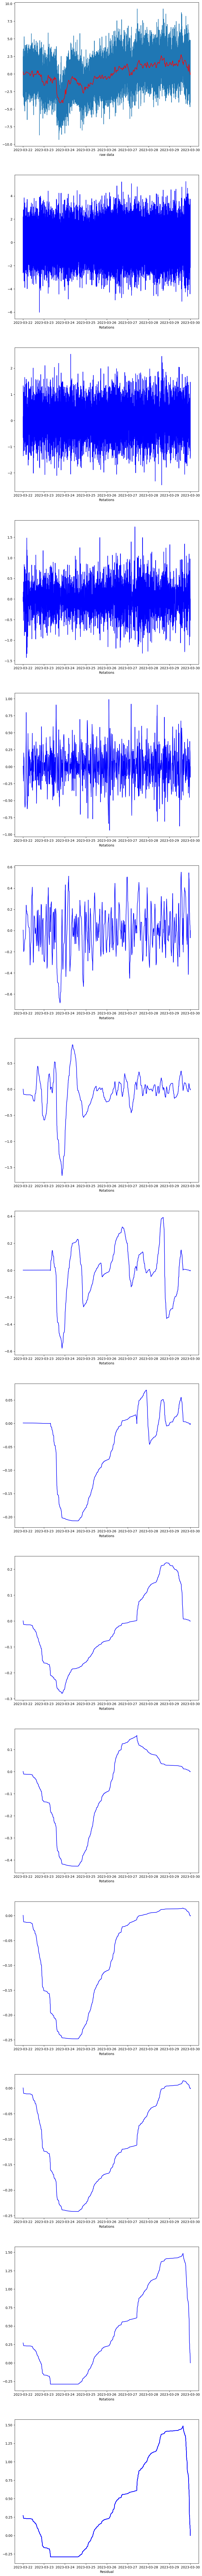

In [71]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import numpy
import math
itd = ITD()


def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)


samples = numpy.asarray(values) 
rotations = itd.itd(samples)
baselines = itd.get_baselines()
rows, columns = baselines.shape
diff = abs(numpy.sum(samples) -  (shewchuk_sum(rotations)))
print("difference between input and ITD output after re-combining all values: ", diff)
fig, (ax) = plt.subplots(rows+2,figsize=(10,(rows * 10) + 10))

ax[0].set_xlabel('raw data')
ax[0].plot(dates, samples)
ax[0].plot(dates, baselines[3,:], 'r') #Значением baselines[n,:] можно поиграться
for i in range(rows):
    ax[i+1].set_xlabel('Rotations')
    ax[i+1].plot(dates, rotations[i,:],'b')                             
    ax[-1].set_xlabel('Residual')
    ax[-1].plot(dates, rotations[-1,:],'b')                                

In [72]:
from nemo.make_df import make_df

data = make_df('nemo/2023-2023/Measured_data/21_04-03_05')

dates = data['date']
values = data['value'].values

Out of time!
difference between input and ITD output after re-combining all values:  1.3163775625102403e-13


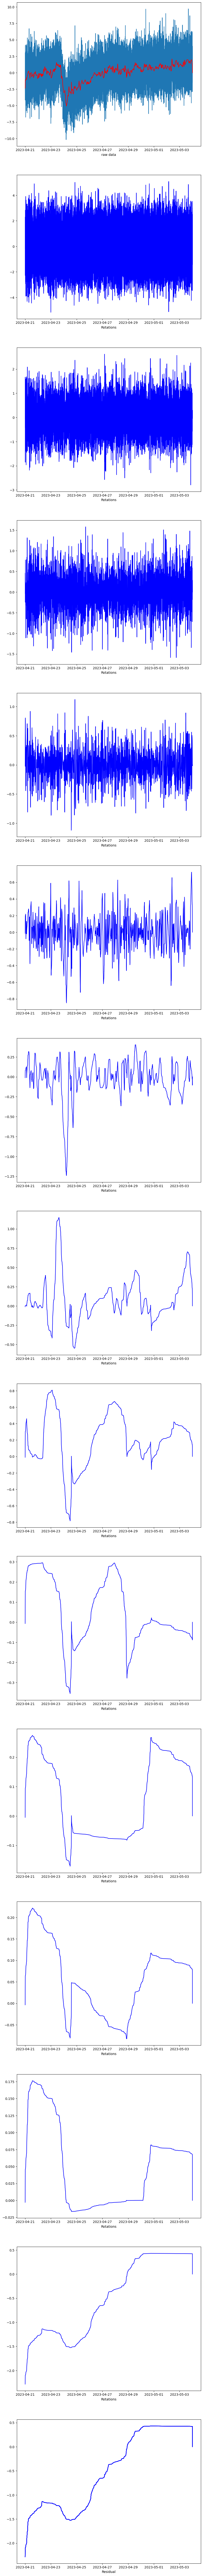

In [73]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import numpy
import math
itd = ITD()


def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)


samples = numpy.asarray(values) 
rotations = itd.itd(samples)
baselines = itd.get_baselines()
rows, columns = baselines.shape
diff = abs(numpy.sum(samples) -  (shewchuk_sum(rotations)))
print("difference between input and ITD output after re-combining all values: ", diff)
fig, (ax) = plt.subplots(rows+2,figsize=(10,(rows * 10) + 10))

ax[0].set_xlabel('raw data')
ax[0].plot(dates, samples)
ax[0].plot(dates, baselines[3,:], 'r') #Значением baselines[n,:] можно поиграться
for i in range(rows):
    ax[i+1].set_xlabel('Rotations')
    ax[i+1].plot(dates, rotations[i,:],'b')                             
    ax[-1].set_xlabel('Residual')
    ax[-1].plot(dates, rotations[-1,:],'b')                                

In [76]:
from nemo.make_df import make_df

data = make_df('nemo/2023-2023/Measured_data/04_05-11-05')

dates = data['date']
values = data['value'].values

Out of time!
difference between input and ITD output after re-combining all values:  5.382500001260837e-14


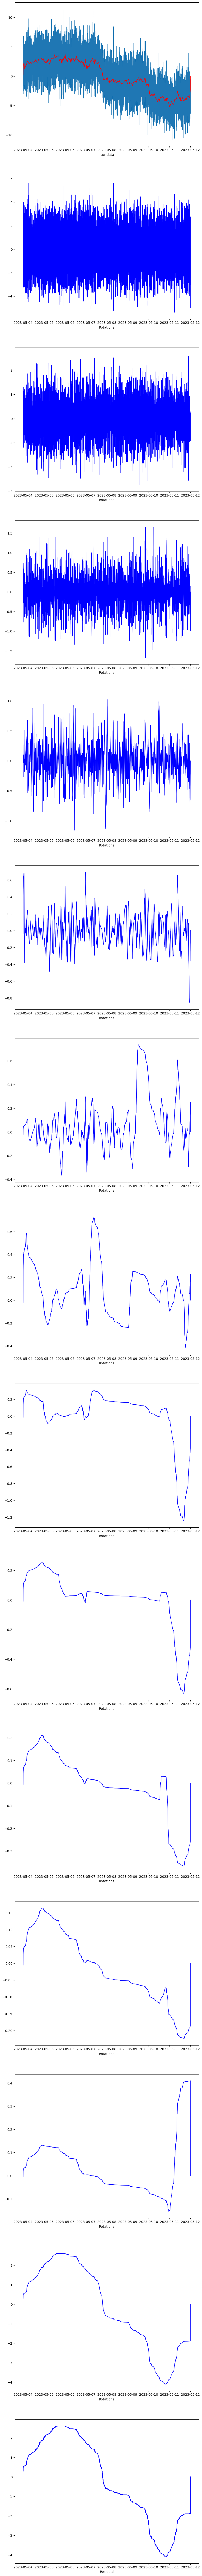

In [77]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import numpy
import math
itd = ITD()


def shewchuk_sum(a, axis=0):
    '''shewchuck summation of a numpy array.
    '''
    s = numpy.zeros(a.shape[1])
    for i in range(a.shape[1]):
        s[i] = math.fsum(a[:,i])
    return math.fsum(s)


samples = numpy.asarray(values) 
rotations = itd.itd(samples)
baselines = itd.get_baselines()
rows, columns = baselines.shape
diff = abs(numpy.sum(samples) -  (shewchuk_sum(rotations)))
print("difference between input and ITD output after re-combining all values: ", diff)
fig, (ax) = plt.subplots(rows+2,figsize=(10,(rows * 10) + 10))

ax[0].set_xlabel('raw data')
ax[0].plot(dates, samples)
ax[0].plot(dates, baselines[3,:], 'r') #Значением baselines[n,:] можно поиграться
for i in range(rows):
    ax[i+1].set_xlabel('Rotations')
    ax[i+1].plot(dates, rotations[i,:],'b')                             
    ax[-1].set_xlabel('Residual')
    ax[-1].plot(dates, rotations[-1,:],'b')                                